# Red Wine Classification

In [37]:
from pandas import Series, DataFrame
import pandas as pd
from patsy import dmatrices
import seaborn as sns
%pylab inline
import warnings
warnings.filterwarnings('ignore')

%pylab is deprecated, use %matplotlib inline and import the required libraries.
Populating the interactive namespace from numpy and matplotlib


In [38]:
from sklearn import tree
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, GradientBoostingClassifier

In [39]:
df = pd.read_csv('winequality-red.csv', sep=";")
df =df.drop_duplicates()
# df_temp = df.drop('quality', axis=1)
# df_norm = (df_temp-df_temp.min())/(df_temp.max()-df_temp.min())
# q = df['quality'].apply(lambda x: 1 if x > 6 else 0)
# df_norm = pd.concat((df_norm, q), 1)
# print(df_norm)
# df=df_norm.copy()

In [40]:
df.iloc[0]

fixed acidity            7.4000
volatile acidity         0.7000
citric acid              0.0000
residual sugar           1.9000
chlorides                0.0760
free sulfur dioxide     11.0000
total sulfur dioxide    34.0000
density                  0.9978
pH                       3.5100
sulphates                0.5600
alcohol                  9.4000
quality                  5.0000
Name: 0, dtype: float64

### Create formula for design matrices

In [41]:
formula = 'quality ~ ' + ' + '.join(['Q("'+x+'")' \
                                    for x in df.columns.values\
                                    if x != 'quality'])
print(formula)

quality ~ Q("fixed acidity") + Q("volatile acidity") + Q("citric acid") + Q("residual sugar") + Q("chlorides") + Q("free sulfur dioxide") + Q("total sulfur dioxide") + Q("density") + Q("pH") + Q("sulphates") + Q("alcohol")


The **Q()** function stands for _quoting_, and is necessary when you have features like **char\_freq\_(**, in which the parenthesis throws off the _dmatrices()_ function. **Q("char\_freq\_(")** tells Python to consider the entire thing as a string.

## Create design matrices

In [42]:
Y, X = dmatrices(formula, df, return_type='dataframe')
y = Y['quality'].values

## Create training and testing sets

In [43]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y,
                                                    test_size=0.3,
                                                    random_state=1)

## Set up all the classifiers

In [44]:
# All the models we want to test out
models = {}
models['Decision Tree'] = \
    tree.DecisionTreeClassifier(criterion='entropy')

models['Bagging'] = \
    BaggingClassifier(
        tree.DecisionTreeClassifier(criterion='entropy'),
        random_state=1)

models['Random Forest'] = \
    RandomForestClassifier(n_estimators=10,
                           random_state=1)

models['Gradient Boosting'] = \
    GradientBoostingClassifier(n_estimators=200,
                               max_depth=3,
                               random_state=1)

## Fit the models

In [45]:
for name, model in models.items():
    print('Fitting', name)
    model.fit(X_train, y_train)

Fitting Decision Tree
Fitting Bagging
Fitting Random Forest
Fitting Gradient Boosting


## Accuracy scores

In [46]:
from sklearn import metrics

accuracy_train = {}
accuracy_test = {}
for name, model in models.items():
    prediction_train = model.predict(X_train)
    accuracy_train[name] = metrics.accuracy_score(y_train, prediction_train)
    prediction_test = model.predict(X_test)
    accuracy_test[name] = metrics.accuracy_score(y_test, prediction_test)
    
df = DataFrame({'Training Accuracy':accuracy_train, 'Test Accuracy':accuracy_test})
df

,Training Accuracy,Test Accuracy
Decision Tree,1.000000,0.455882
Bagging,0.990536,0.514706
Random Forest,0.994742,0.546569
Gradient Boosting,0.986330,0.558824


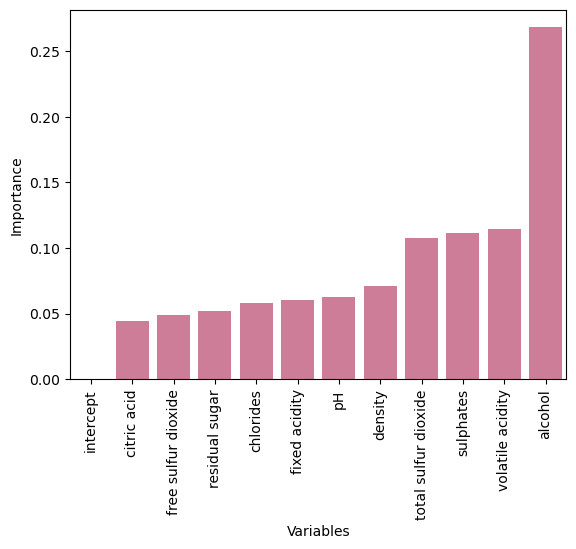

In [47]:
names =np.insert(df_norm.columns.values[0:11], 0, 'intercept')
#names
var_imp=pd.Series(models['Gradient Boosting'].feature_importances_,index=names)
var_imp_df = var_imp.reset_index()
var_imp_df.columns = ['Variables', 'Importance']
var_imp_df.sort_values(by='Importance',inplace=True)
bar_plot=sns.barplot(x='Variables',y='Importance',data=var_imp_df,color='palevioletred')
plt.xticks(rotation=90)
plt.show()

All the classifiers seem to overfit; their training accuracy is much higher than their test accuracy.

How does accuracy of gradient boosting depend on the number of trees and their depth?

Text(0, 0.5, 'Test accuracy')

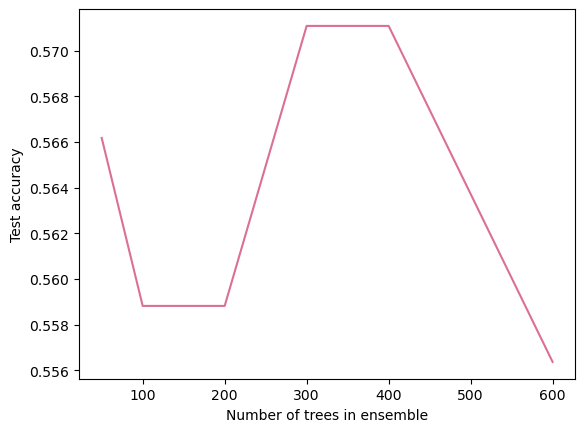

In [48]:
scores = {}
for num_trees in [50, 100, 200, 300, 400, 500, 600]:
    model = GradientBoostingClassifier(n_estimators=num_trees,
                                       max_depth=3,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[num_trees] = accuracy_test
Series(scores).sort_index().plot(color='palevioletred')
xlabel('Number of trees in ensemble')
ylabel('Test accuracy')

200 trees seem to be enough.

How about the depth of the trees?

Text(0, 0.5, 'Test accuracy')

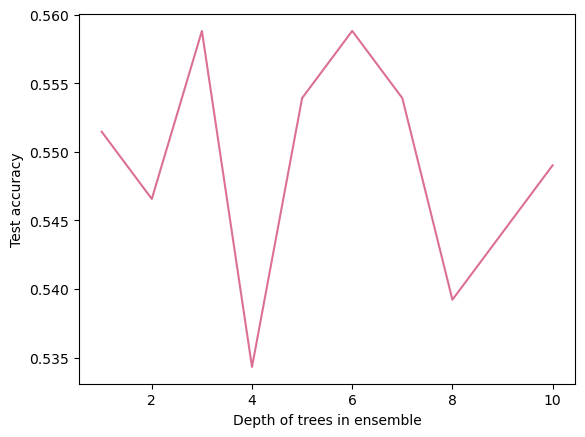

In [49]:
scores = {}
for depth in range(1, 11):
    model = GradientBoostingClassifier(n_estimators=200,
                                       max_depth=depth,
                                       random_state=1)
    model.fit(X_train, y_train)
    prediction_test = model.predict(X_test)
    accuracy_test = metrics.accuracy_score(y_test, prediction_test)
    scores[depth] = accuracy_test
Series(scores).sort_index().plot(color='palevioletred')
xlabel('Depth of trees in ensemble')
ylabel('Test accuracy')

Trees of depth 3 seem to be enough.